In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt


In [ ]:
try:
    from nibabel import load
except ImportError:
    raise ImportError('You need nibabel (http:/nipy.org/nibabel/) in order to run this example')

In [ ]:
!pip install nitime



In [ ]:
import nitime
import nitime.analysis as nta
import nitime.fmri.io as io

In [ ]:
def parametros():
  TR = float(input('Informe o valor do TR [1.35]: '))
  f_lb = float(input('Informe o valor de f_lb [0.02]: '))
  f_ub = float(input('Informe o valor de f_lb [0.15]: '))
  return TR, f_lb, f_ub

In [ ]:
TR, f_lb, f_ub = parametros()

In [ ]:
data_path = test_dir_path = os.path.join(nitime.__path__[0], 'data')

fmri_file = os.path.join(data_path, 'fmri1.nii.gz')

In [ ]:
fmri_data = load(fmri_file)

In [ ]:
volume_shape = fmri_data.shape[:-1]

coords = list(np.ndindex(volume_shape))

In [ ]:
n_seeds = 3

In [ ]:
seeds = np.random.randint(0, len(coords), n_seeds)
coords_seeds = np.array(coords)[seeds].T

In [ ]:
coords_target = np.array(coords).T

In [ ]:
time_series_seed = io.time_series_from_file(fmri_file, coords_seeds, TR=TR, normalize='percent', filter=dict(lb=f_lb, ub=f_ub, method='boxcar'))

In [ ]:
time_series_target = io.time_series_from_file(fmri_file, coords_target, TR=TR, normalize='percent',filter=dict(lb=f_lb, ub=f_ub, method='boxcar'))

In [ ]:
A = nta.SeedCoherenceAnalyzer(time_series_seed, time_series_target, method=dict(NFFT=20))

In [ ]:
B = nta.SeedCorrelationAnalyzer(time_series_seed, time_series_target)

In [ ]:
freq_idx = np.where((A.frequencies > f_lb) * (A.frequencies < f_ub))[0]

In [ ]:
cor = []
coh = []
for this_seed in range(n_seeds):
  coh.append(np.mean(A.coherence[this_seed][:, freq_idx], -1))  
  cor.append(B.corrcoef[this_seed]) 

In [ ]:
coords_indices = list(coords_target)

vol_coh = []
vol_cor = []
for this_vol in range(n_seeds):
    vol_coh.append(np.empty(volume_shape))
    vol_coh[-1][coords_indices] = coh[this_vol]
    vol_cor.append(np.empty(volume_shape))
    vol_cor[-1][coords_indices] = cor[this_vol]
    

In [ ]:
random_slice = np.random.randint(0, volume_shape[-1], 1)

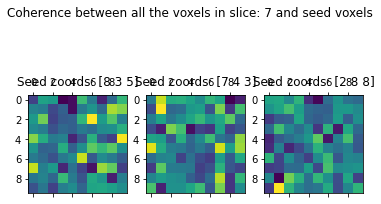

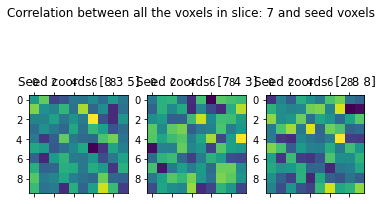

In [53]:
fig01 = plt.figure()
fig02 = plt.figure()
ax_coh = []
ax_cor = []
for this_vox in range(n_seeds):
    ax_coh.append(fig01.add_subplot(1, n_seeds, this_vox + 1))
    ax_coh[-1].matshow(vol_coh[this_vox][:, :, random_slice].squeeze())
    ax_coh[-1].set_title('Seed coords: %s' % coords_seeds[:, this_vox])

    ax_cor.append(fig02.add_subplot(1, n_seeds, this_vox + 1))
    ax_cor[-1].matshow(vol_cor[this_vox][:, :, random_slice].squeeze())
    ax_cor[-1].set_title('Seed coords: %s' % coords_seeds[:, this_vox])

for x in zip(['Coherence', 'Correlation'], [fig01, fig02]):
    suptit = '%s between all the voxels in slice: ' % x[0]
    suptit += '%i and seed voxels' % random_slice
    x[1].suptitle(suptit)

plt.show()